In [1]:
# load python libraries
import sys
import cv2
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.titlesize'] = 28 # set global title size for plots

# load custom libraries
sys.path.append("../tools")
from utils import *

In [2]:
# load data for training and evaluation
train_img_paths, train_img_labels, test_img_paths, test_img_labels, _ = get_paths_and_labels()

# Preliminary Assessment

This notebook explores the contents of the raw data to see if simple actions (such as choosing a single color channel or changing the brightness of the images) helps make some image features relevant to our application more predominant.

## Raw Data Analysis

### Check if we can get an advantage by using a particular color channel

**First step:** Compare raindrops and no raindrops pairs.

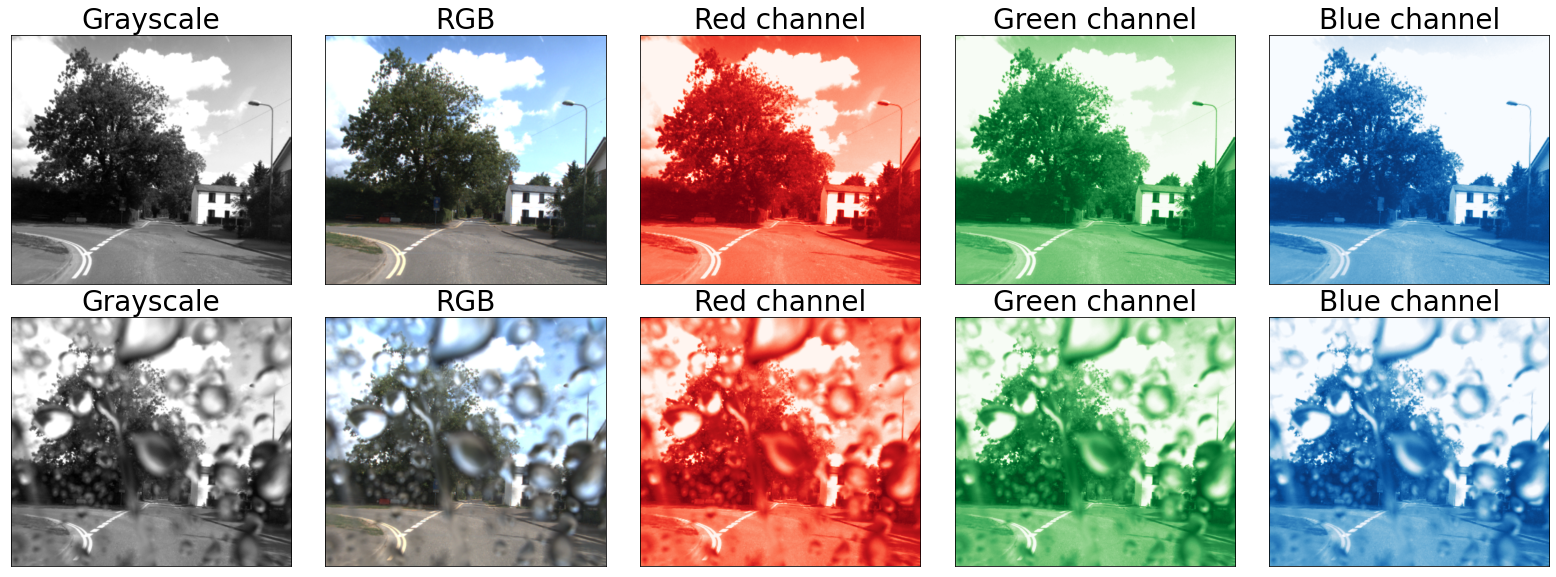

In [3]:
fig, ax = plt.subplots(2,5,figsize=(22,8))
plt.setp(ax,xticks=[],yticks=[])

idx = 0
for ix,i in enumerate([idx,idx+503]):

    im = cv2.imread(train_img_paths[i])

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im_r = im[...,0]
    im_g = im[...,1]
    im_b = im[...,2]

    ax[ix,0].imshow(im_gray,cmap='gray')
    ax[ix,0].set_title('Grayscale')

    ax[ix,1].imshow(im)
    ax[ix,1].set_title('RGB')

    ax[ix,2].imshow(im_r,cmap='Reds_r')
    ax[ix,2].set_title('Red channel')

    ax[ix,3].imshow(im_g,cmap='Greens_r')
    ax[ix,3].set_title('Green channel')

    ax[ix,4].imshow(im_b,cmap='Blues_r')
    ax[ix,4].set_title('Blue channel')

fig.tight_layout()
plt.show()

**Observation:** When checking the image at index 0, I learned that clouds become less prominent in the blue channel.

### Check what kind of texture raindrops produce

**Second step:** Textures can be of high or low frequency, knowing the frequency level will help us decide what kind filters can be beneficial for our purposes.

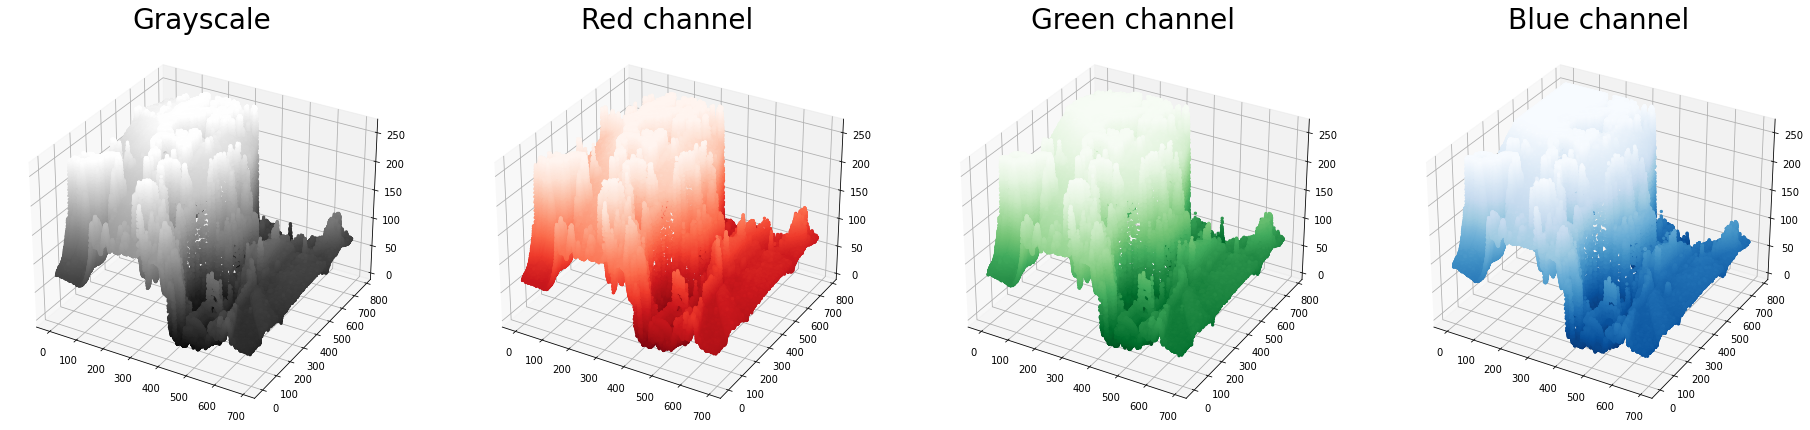

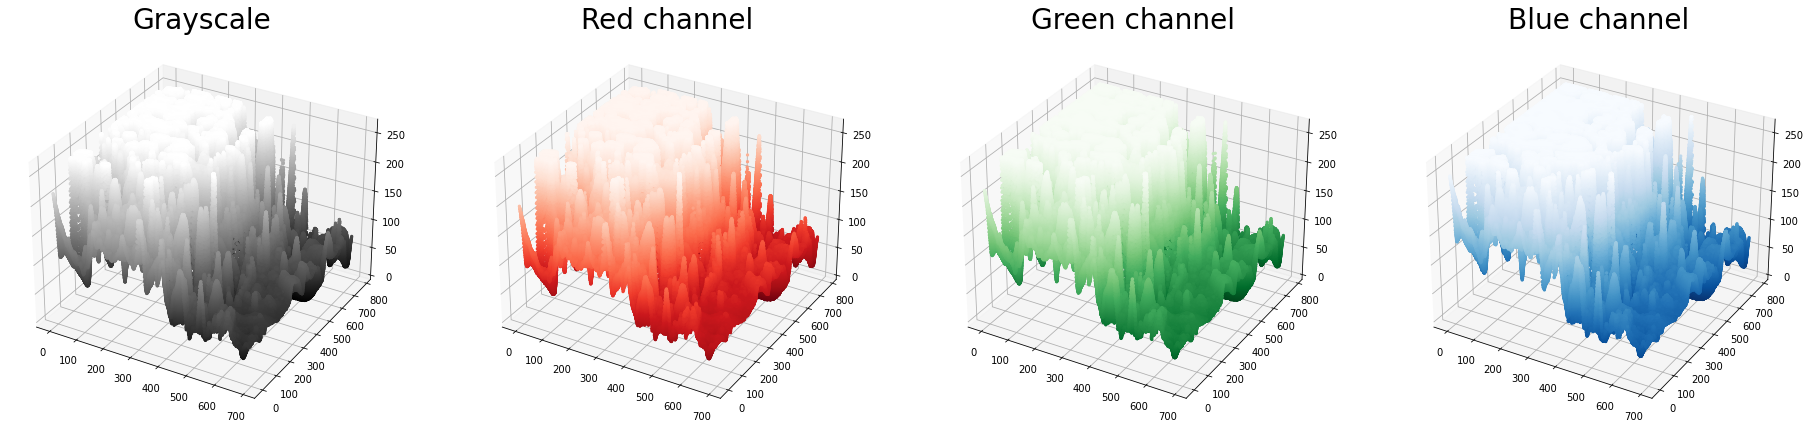

In [4]:
idx = 2
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i])
    
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_r = im[...,2]
    im_g = im[...,1]
    im_b = im[...,0]

    fig = plt.figure(figsize=(32,8))
    plot_parameters = {'s':5,'depthshade':False}

    ax1 = fig.add_subplot(141, projection='3d')
    x,y,z = array2xyz(im_gray)
    ax1.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax1.set_title('Grayscale')

    ax2 = fig.add_subplot(142, projection='3d')
    x,y,z = array2xyz(im_r)
    ax2.scatter(x,y,z,c=z,cmap='Reds_r',**plot_parameters)
    ax2.set_title('Red channel')

    ax3 = fig.add_subplot(143, projection='3d')
    x,y,z = array2xyz(im_g)
    ax3.scatter(x,y,z,c=z,cmap='Greens_r',**plot_parameters)
    ax3.set_title('Green channel')
    
    ax3 = fig.add_subplot(144, projection='3d')
    x,y,z = array2xyz(im_b)
    ax3.scatter(x,y,z,c=z,cmap='Blues_r',**plot_parameters)
    ax3.set_title('Blue channel')

    plt.show()

**Observation:** Based on the ondulatory behavior of the raindrops sample, I learned that raindrops generate high frequency textures.

## Filtering Preview
### Test different filters to get a sense of their effects
**Third step:** The best way to deal with high-frequency textures is to either smooth the image to blur these textures (Gaussian filtering) or create even more contrast to highlight these textures (Median filtering).

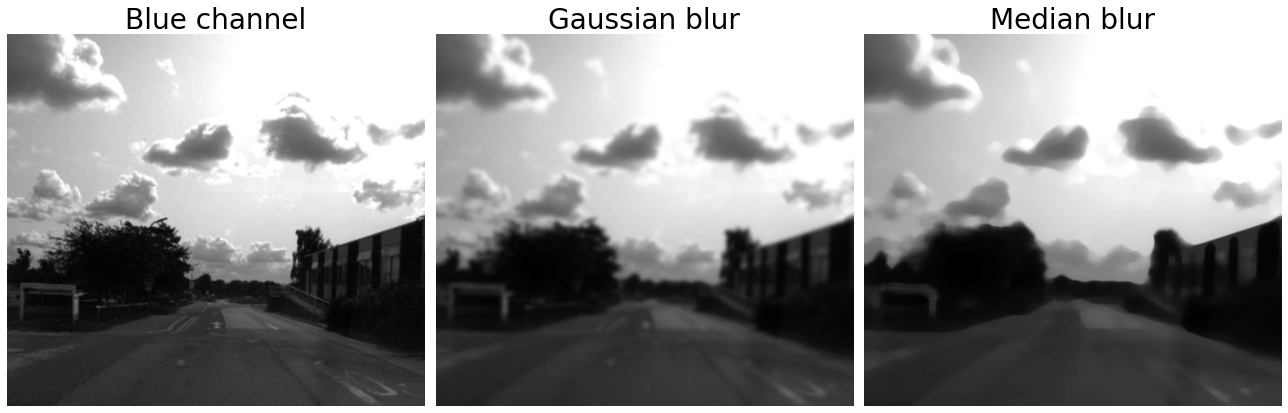

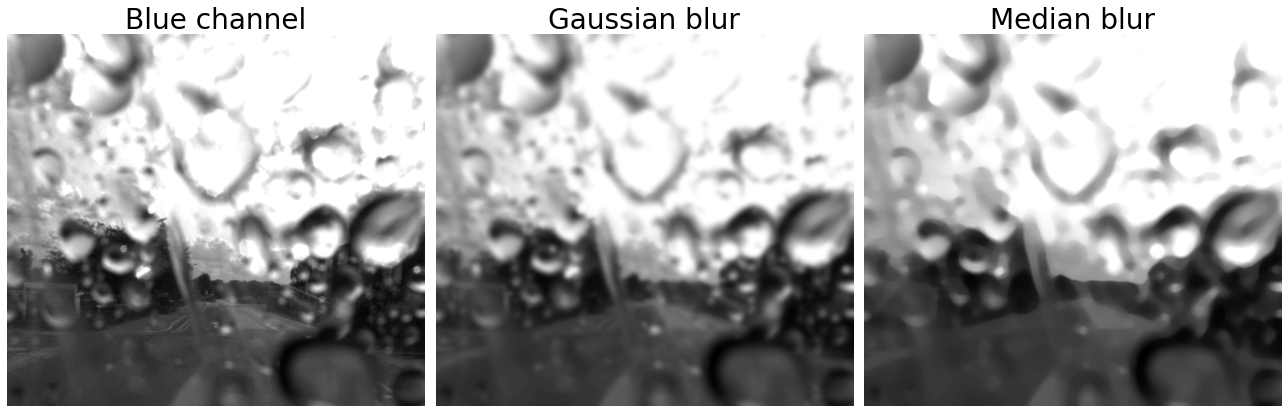

In [5]:
idx = 2
for i in [idx,idx+503]:

    im = cv2.imread(train_img_paths[i])
    im_b = im[...,0]

    im_blur1 = cv2.GaussianBlur(im_b,(21,21),0)
    im_blur2 = cv2.medianBlur(im_b,21)
    
    fig, ax = plt.subplots(1,3,figsize=(18,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_b,cmap='gray')
    ax[0].set_title('Blue channel')

    ax[1].imshow(im_blur1,cmap='gray')
    ax[1].set_title('Gaussian blur')

    ax[2].imshow(im_blur2,cmap='gray')
    ax[2].set_title('Median blur')

    fig.tight_layout()
    plt.show()

**Observation:** Some images like the one at index 2 have a serious brightness problem with the ground being too dark and the sky being too bright. As we filter the image, this huge contrast in brightness will cause some raindrops to disappear. Hence, I learned that this is a problem that needs fixing.

## Segmentation Preview
### Try thresholding filtered images
**Fourth step:** As I might want to segment the image to detect raindrops, I want to see how serious this brightness problem is and what I should expect when creating a mask with these images.

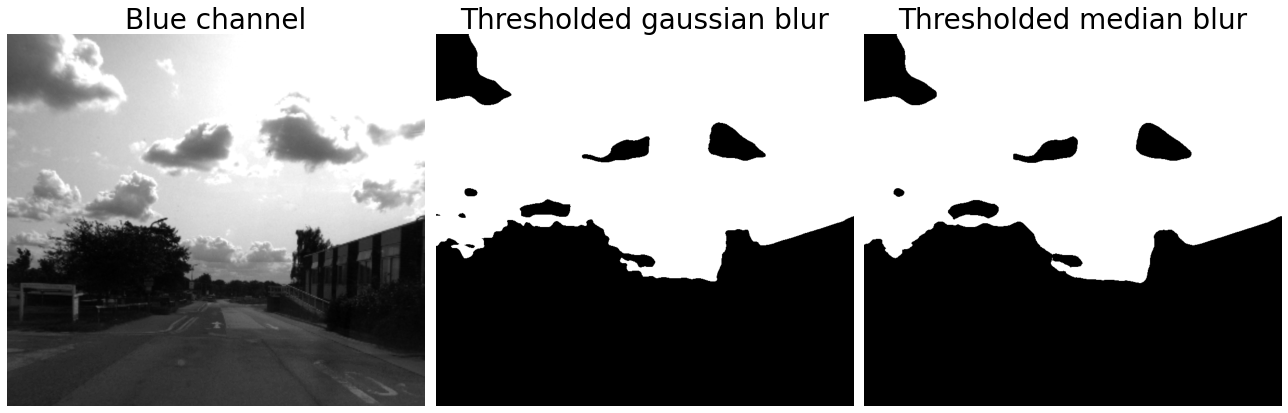

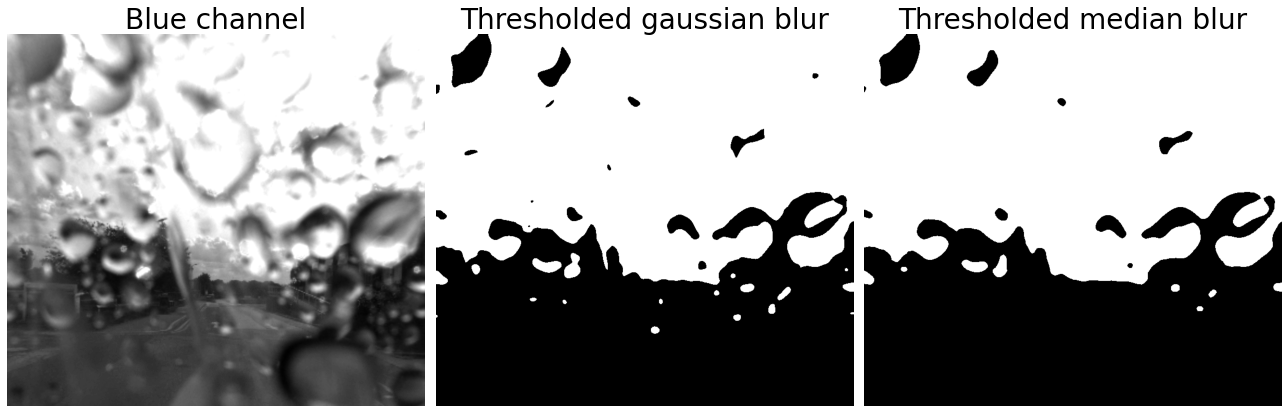

In [6]:
idx = 2
for i in [idx,idx+503]:

    im = cv2.imread(train_img_paths[i])
    im_b = im[...,0]

    im_blur1 = cv2.GaussianBlur(im_b,(21,21),0)
    im_th1 = cv2.threshold(im_blur1,127,255,cv2.THRESH_BINARY)[1]
    
    im_blur2 = cv2.medianBlur(im_b,21)
    im_th2 = cv2.threshold(im_blur2,127,255,cv2.THRESH_BINARY)[1]

    fig, ax = plt.subplots(1,3,figsize=(18,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_b,cmap='gray')
    ax[0].set_title('Blue channel')

    ax[1].imshow(im_th1,cmap='gray')
    ax[1].set_title('Thresholded gaussian blur')

    ax[2].imshow(im_th2,cmap='gray')
    ax[2].set_title('Thresholded median blur')

    fig.tight_layout()
    plt.show()

**Observation:** The above masks don't look so good as many raindrops dissappeared. Therefore, I learned that I should try a different threshold value.

### Plot filtered images as 3D plots to help me decide on a threshold value

**Fifth step:** Plot the image as a 3D plot by using the image coordinates as x and y values and the pixel value as the z value. With this I will be able to decide if a different threshold value will fix my problem.

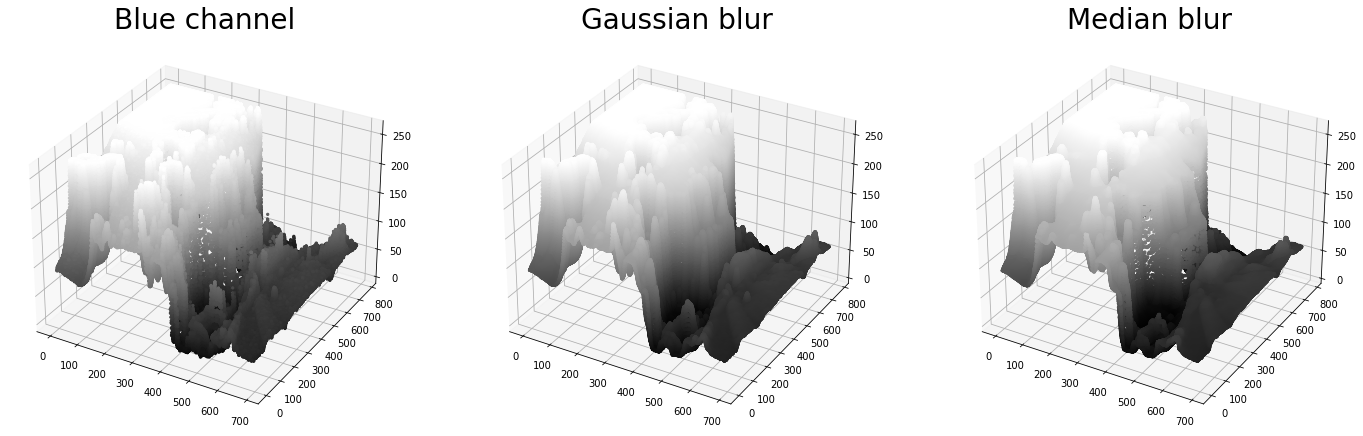

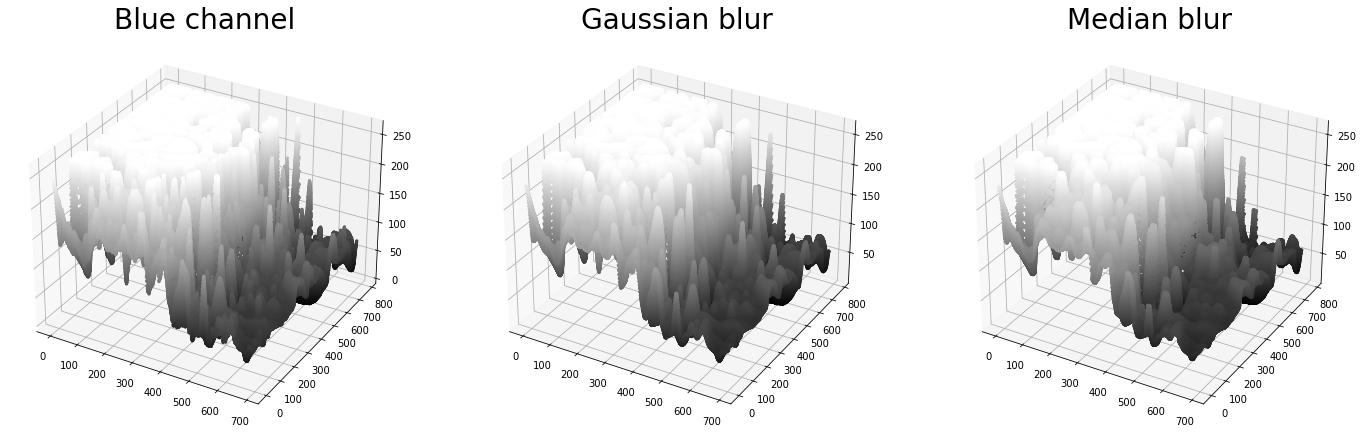

In [7]:
idx = 2
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i])
    im_b = im[...,0]

    im_blur1 = cv2.GaussianBlur(im_b,(21,21),0)
    im_blur2 = cv2.medianBlur(im_b,21)

    fig = plt.figure(figsize=(24,8))
    plot_parameters = {'s':5,'depthshade':False}

    ax1 = fig.add_subplot(131, projection='3d')
    x,y,z = array2xyz(im_b)
    ax1.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax1.set_title('Blue channel')

    ax2 = fig.add_subplot(132, projection='3d')
    x,y,z = array2xyz(im_blur1)
    ax2.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax2.set_title('Gaussian blur')

    ax3 = fig.add_subplot(133, projection='3d')
    x,y,z = array2xyz(im_blur2)
    ax3.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax3.set_title('Median blur')

    plt.show()

**Observation:** Based on the 3D plots above, I learned that a different threshold value won't fix my brightness problem. I already chose 127 (right in the middle) and got unsatisfactory results. If I go above 127, I will miss all the raindrops in the dark ground. If I go below 127, I will miss all the raindrops in the bright sky.

## Gamma Correction
### Try to correct the gamma factor in the images to deal with the brightness problem
**Sixth step:** One way to adjust the brightness of an image is to change the gamma factor, which is 1 by default.

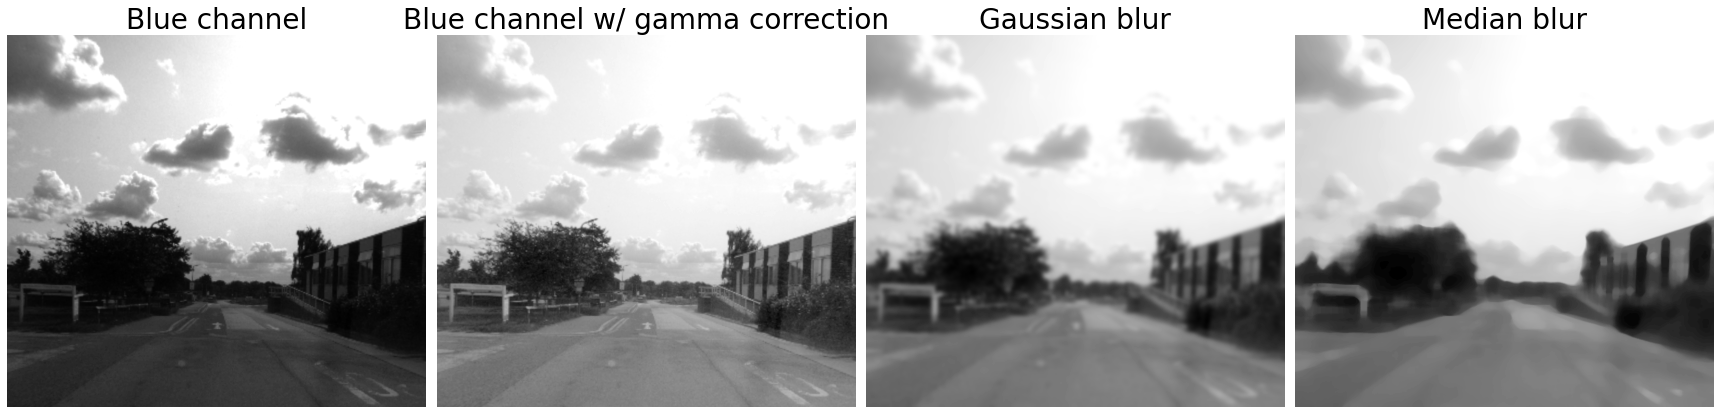

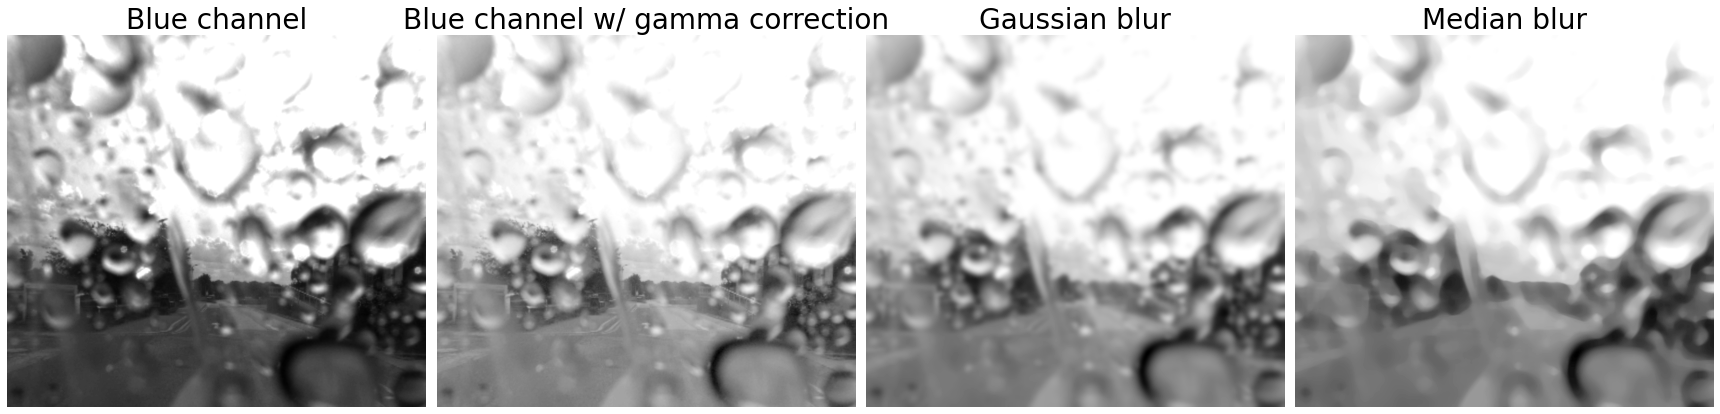

In [8]:
idx = 2
for i in [idx,idx+503]:

    im = cv2.imread(train_img_paths[i])
    im_b = im[...,0]

    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = normalize(im_gamma)*255
    im_gamma = im_gamma.astype(np.uint8)
    
    im_blur1 = cv2.GaussianBlur(im_gamma,(21,21),0)
    im_blur2 = cv2.medianBlur(im_gamma,21)
    
    fig, ax = plt.subplots(1,4,figsize=(24,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_b,cmap='gray')
    ax[0].set_title('Blue channel')

    ax[1].imshow(im_gamma,cmap='gray')
    ax[1].set_title('Blue channel w/ gamma correction')

    ax[2].imshow(im_blur1,cmap='gray')
    ax[2].set_title('Gaussian blur')
    
    ax[3].imshow(im_blur2,cmap='gray')
    ax[3].set_title('Median blur')

    fig.tight_layout()
    plt.show()

**Observation:** There is a clear change in brightness, with less contrast between the ground and the sky. With this, I learned that the proposed gamma correction seems to be enough to fix the brightness problem. 

### Plot filtered images as 3D plots to see the new distribution of pixel values

**Seventh step:** Plot the image as a 3D plot by using the image coordinates as x and y values and the pixel value as the z value. With this I will be able to visually confirm that the brightness problem has been fixed.

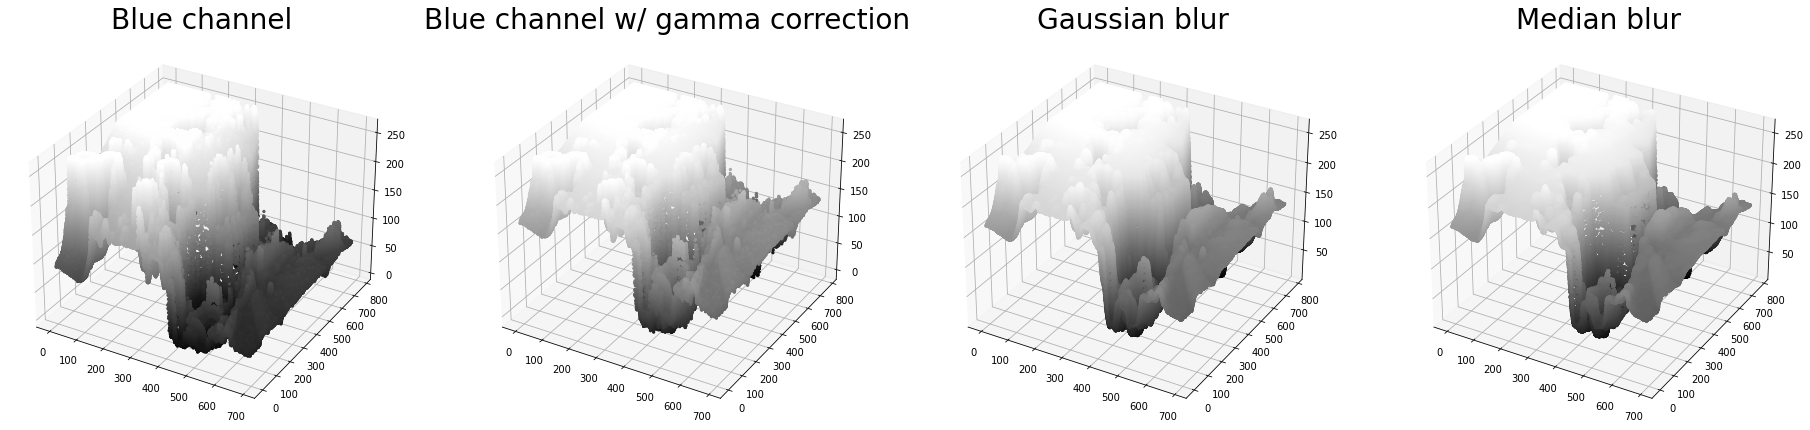

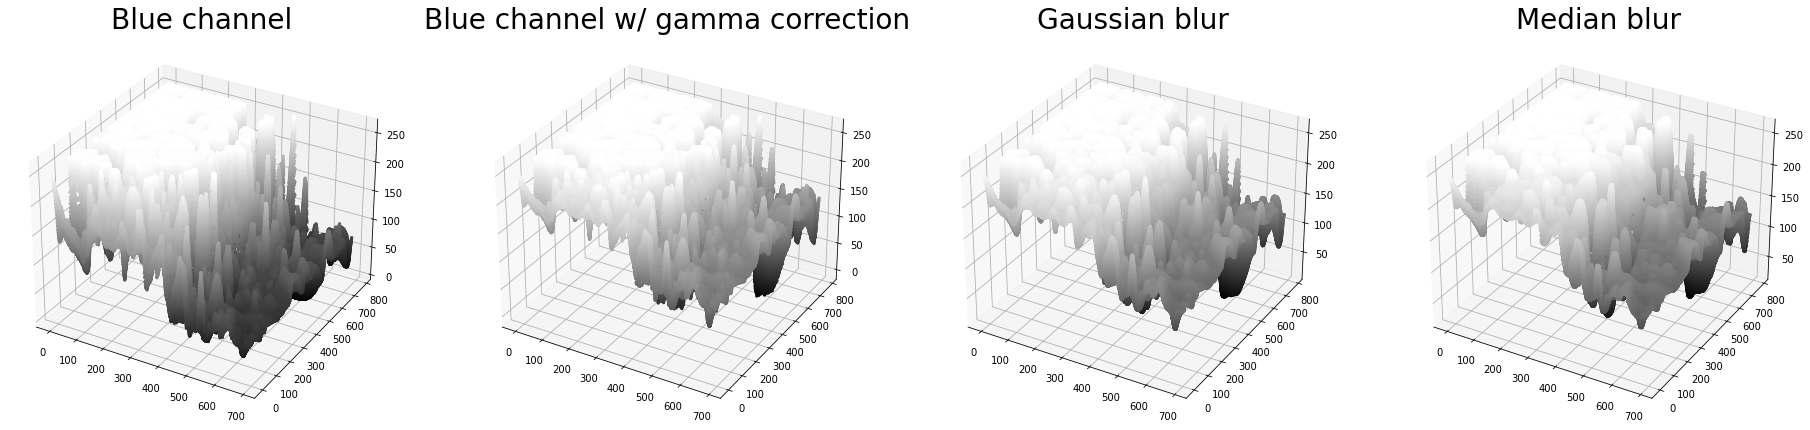

In [9]:
idx = 2
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i])
    im_b = im[...,0]
    
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = normalize(im_gamma)*255
    im_gamma = im_gamma.astype(np.uint8)

    im_blur1 = cv2.GaussianBlur(im_gamma,(21,21),0)
    im_blur2 = cv2.medianBlur(im_gamma,21)

    fig = plt.figure(figsize=(32,8))
    plot_parameters = {'s':5,'depthshade':False}

    ax1 = fig.add_subplot(141, projection='3d')
    x,y,z = array2xyz(im_b)
    ax1.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax1.set_title('Blue channel')

    ax2 = fig.add_subplot(142, projection='3d')
    x,y,z = array2xyz(im_gamma)
    ax2.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax2.set_title('Blue channel w/ gamma correction')

    ax3 = fig.add_subplot(143, projection='3d')
    x,y,z = array2xyz(im_blur1)
    ax3.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax3.set_title('Gaussian blur')
    
    ax4 = fig.add_subplot(144, projection='3d')
    x,y,z = array2xyz(im_blur2)
    ax4.scatter(x,y,z,c=z,cmap='gray',**plot_parameters)
    ax4.set_title('Median blur')

    plt.show()

**Observation:** Based on the rise in pixel values on the ground portion of the image, I have learned that the gamma correction was the right choice.

## Final Remarks
### This analysis has allowed me to:
1) **Avoid clouds** in some images, which were possible sources of falsely detected raindrops, by using only the **blue channel** of all images.

2) **Fix brightness** of some images, which made some raindrops dissappear after filtering and thresholding, by applying **gamma correction** to all images.